# Interannual and multi-year variability

Assessment of model interannual and multi-year variability over the 2000-2019 period.

(Bias corrected data for the period 2000-2019 was produced by training on data from the 1980-1999 period.)

In [45]:
import warnings
warnings.filterwarnings('ignore')

import sys
import numpy as np
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs

sys.path.append('/g/data/xv83/users/at2708/bias_adjustment/evaluation/npcp/results')
import utils

In [46]:
def calc_variab(da, var):
    """Calculate the interannual and multi-year variability"""
    
    if var == 'pr':
        interannual_variab = da.groupby('time.year').sum(dim='time').std(dim='year')
        smoothed_data = da.groupby('time.year').sum(dim='time').rolling(year=5, min_periods=1, center=True).mean()
    else:
        interannual_variab = da.groupby('time.year').mean(dim='time').std(dim='year')
        smoothed_data = da.groupby('time.year').mean(dim='time').rolling(year=5, min_periods=1, center=True).mean()
    multi_year_variab = smoothed_data.std(dim='year')
    return interannual_variab, multi_year_variab

In [47]:
def get_data(var, rcm):
    """Get data needed for the evaluation"""

    assert rcm in ['BOM-BARPA-R', 'UQ-DES-CCAM-2105']
    
    da_obs = utils.get_npcp_data(
        var,
        'observations',
        'AGCD',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )   
    da_gcm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        'GCM',
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_raw = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'raw',
        'task-reference',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    da_rcm_ecdfm = utils.get_npcp_data(
        var,
        'CSIRO-ACCESS-ESM1-5',
        rcm,
        'ecdfm',
        'task-historical',
        '2000-01-01',
        '2019-12-31',
        'AU'
    )
    # TODO: Add additional bias correction methods as data becomes available 

    return da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm

In [58]:
def plot_mean_bias(ax, da_obs, da_model, var, cmap, levels, model_name, mode):
    """Plot the mean bias for a particular model"""
    
    interannual_variab_obs, multi_year_variab_obs = calc_variab(da_obs, var)  
    interannual_variab_model, multi_year_variab_model = calc_variab(da_model, var) 

    if mode == 'interannual':
        bias = interannual_variab_model - interannual_variab_obs
    elif mode == 'multi-year':
        bias = multi_year_variab_model - multi_year_variab_obs
    else:
        print('Invalid mode')
        return
    
    units = 'mm/year' if var == 'pr' else da_model.attrs['units']
    
    im = bias.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend='both', 
        add_colorbar=False
    ) #cbar_kwargs={'label': units},
    ax.set_title(model_name)
    ax.coastlines()
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.04)
    cbar.ax.tick_params(labelsize=14)  
    cbar.set_label(units, fontsize=14) 


In [59]:
def plot_comparison(var, rcm, cmap, levels):
    """Plot the complete comparison"""

    da_obs, da_gcm, da_rcm_raw, da_rcm_ecdfm = get_data(var, rcm)
 
    modes = ['interannual', 'multi-year']  
    
    rows, cols = len(modes), 3  
    
    fig, axs = plt.subplots(rows, cols, figsize=[24, 6*rows], subplot_kw={'projection': ccrs.PlateCarree()})
    
    for row, mode in enumerate(modes): 

        ax1 = axs[row, 0]
        ax2 = axs[row, 1]
        ax3 = axs[row, 2]

        # Plot GCM bias
        plot_mean_bias(ax1, da_obs, da_gcm, var, cmap, levels, 'CSIRO-ACCESS-ESM1-5', mode)
        ax1.set_title(f'CSIRO-ACCESS-ESM1-5 ({mode})', fontsize=16)

        # Plot RCM raw bias
        plot_mean_bias(ax2, da_obs, da_rcm_raw, var, cmap, levels, f'{rcm} (raw)', mode)
        ax2.set_title(f'{rcm} (raw) ({mode})', fontsize=16)

        # Plot RCM bias corrected bias
        plot_mean_bias(ax3, da_obs, da_rcm_ecdfm, var, cmap, levels, f'{rcm} (ecdfm)', mode)
        ax3.set_title(f'{rcm} (ecdfm) ({mode})', fontsize=16)
    
    long_name = da_rcm_raw.attrs['long_name']
    plt.suptitle(f' Variability bias (model minus obs) in the 2000-2019 {long_name}', fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


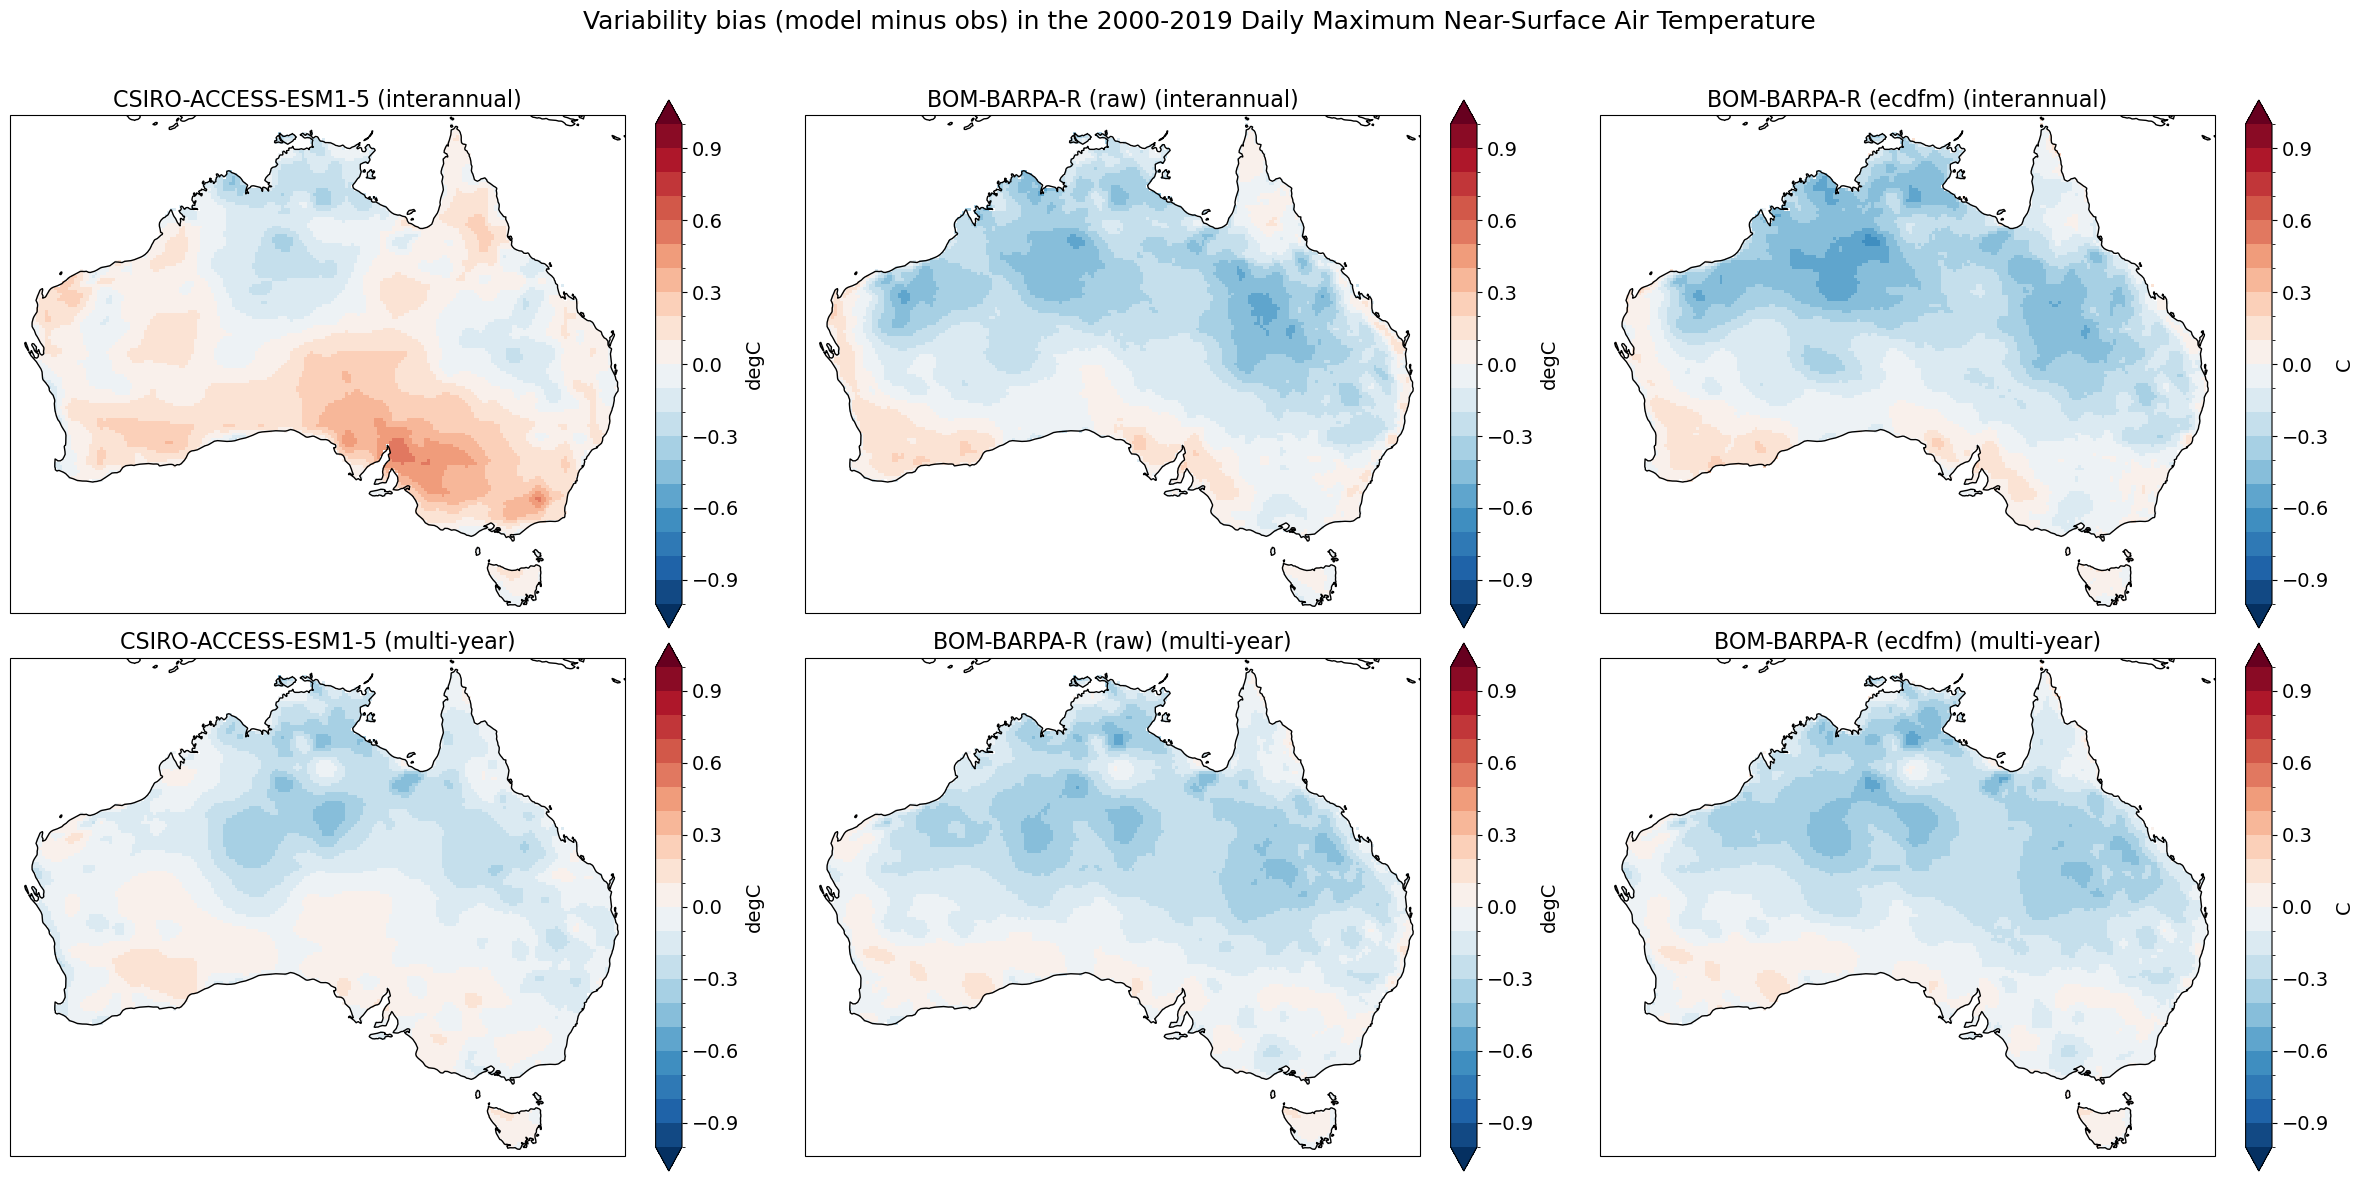

In [50]:
plot_comparison('tasmax', 'BOM-BARPA-R', 'RdBu_r', np.arange(-1, 1.01, 0.1))

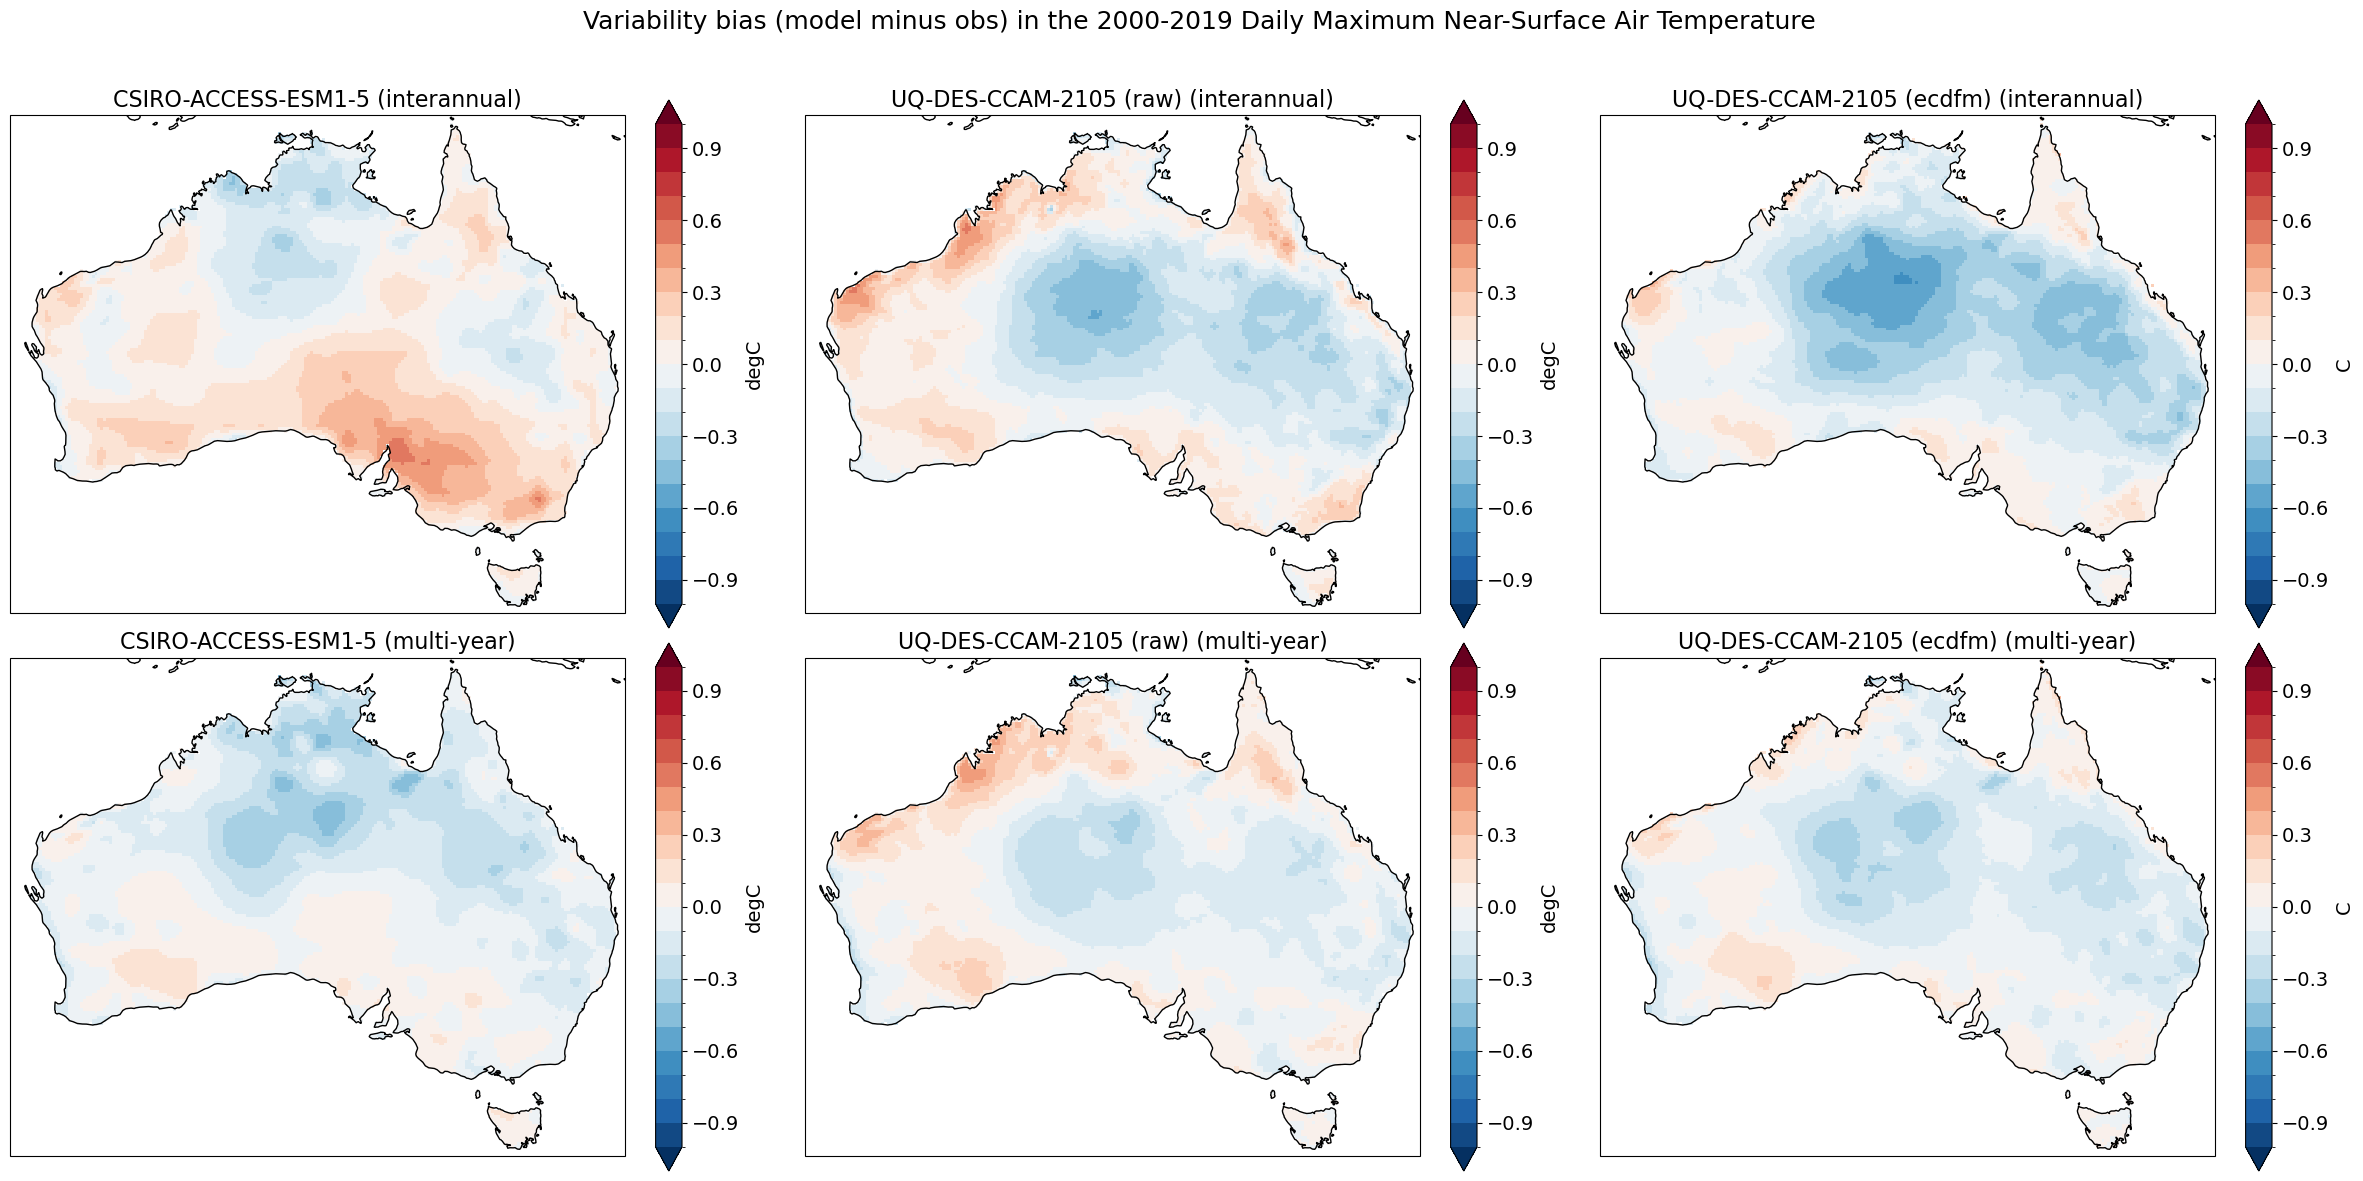

In [53]:
plot_comparison('tasmax', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-1, 1.01, 0.1))

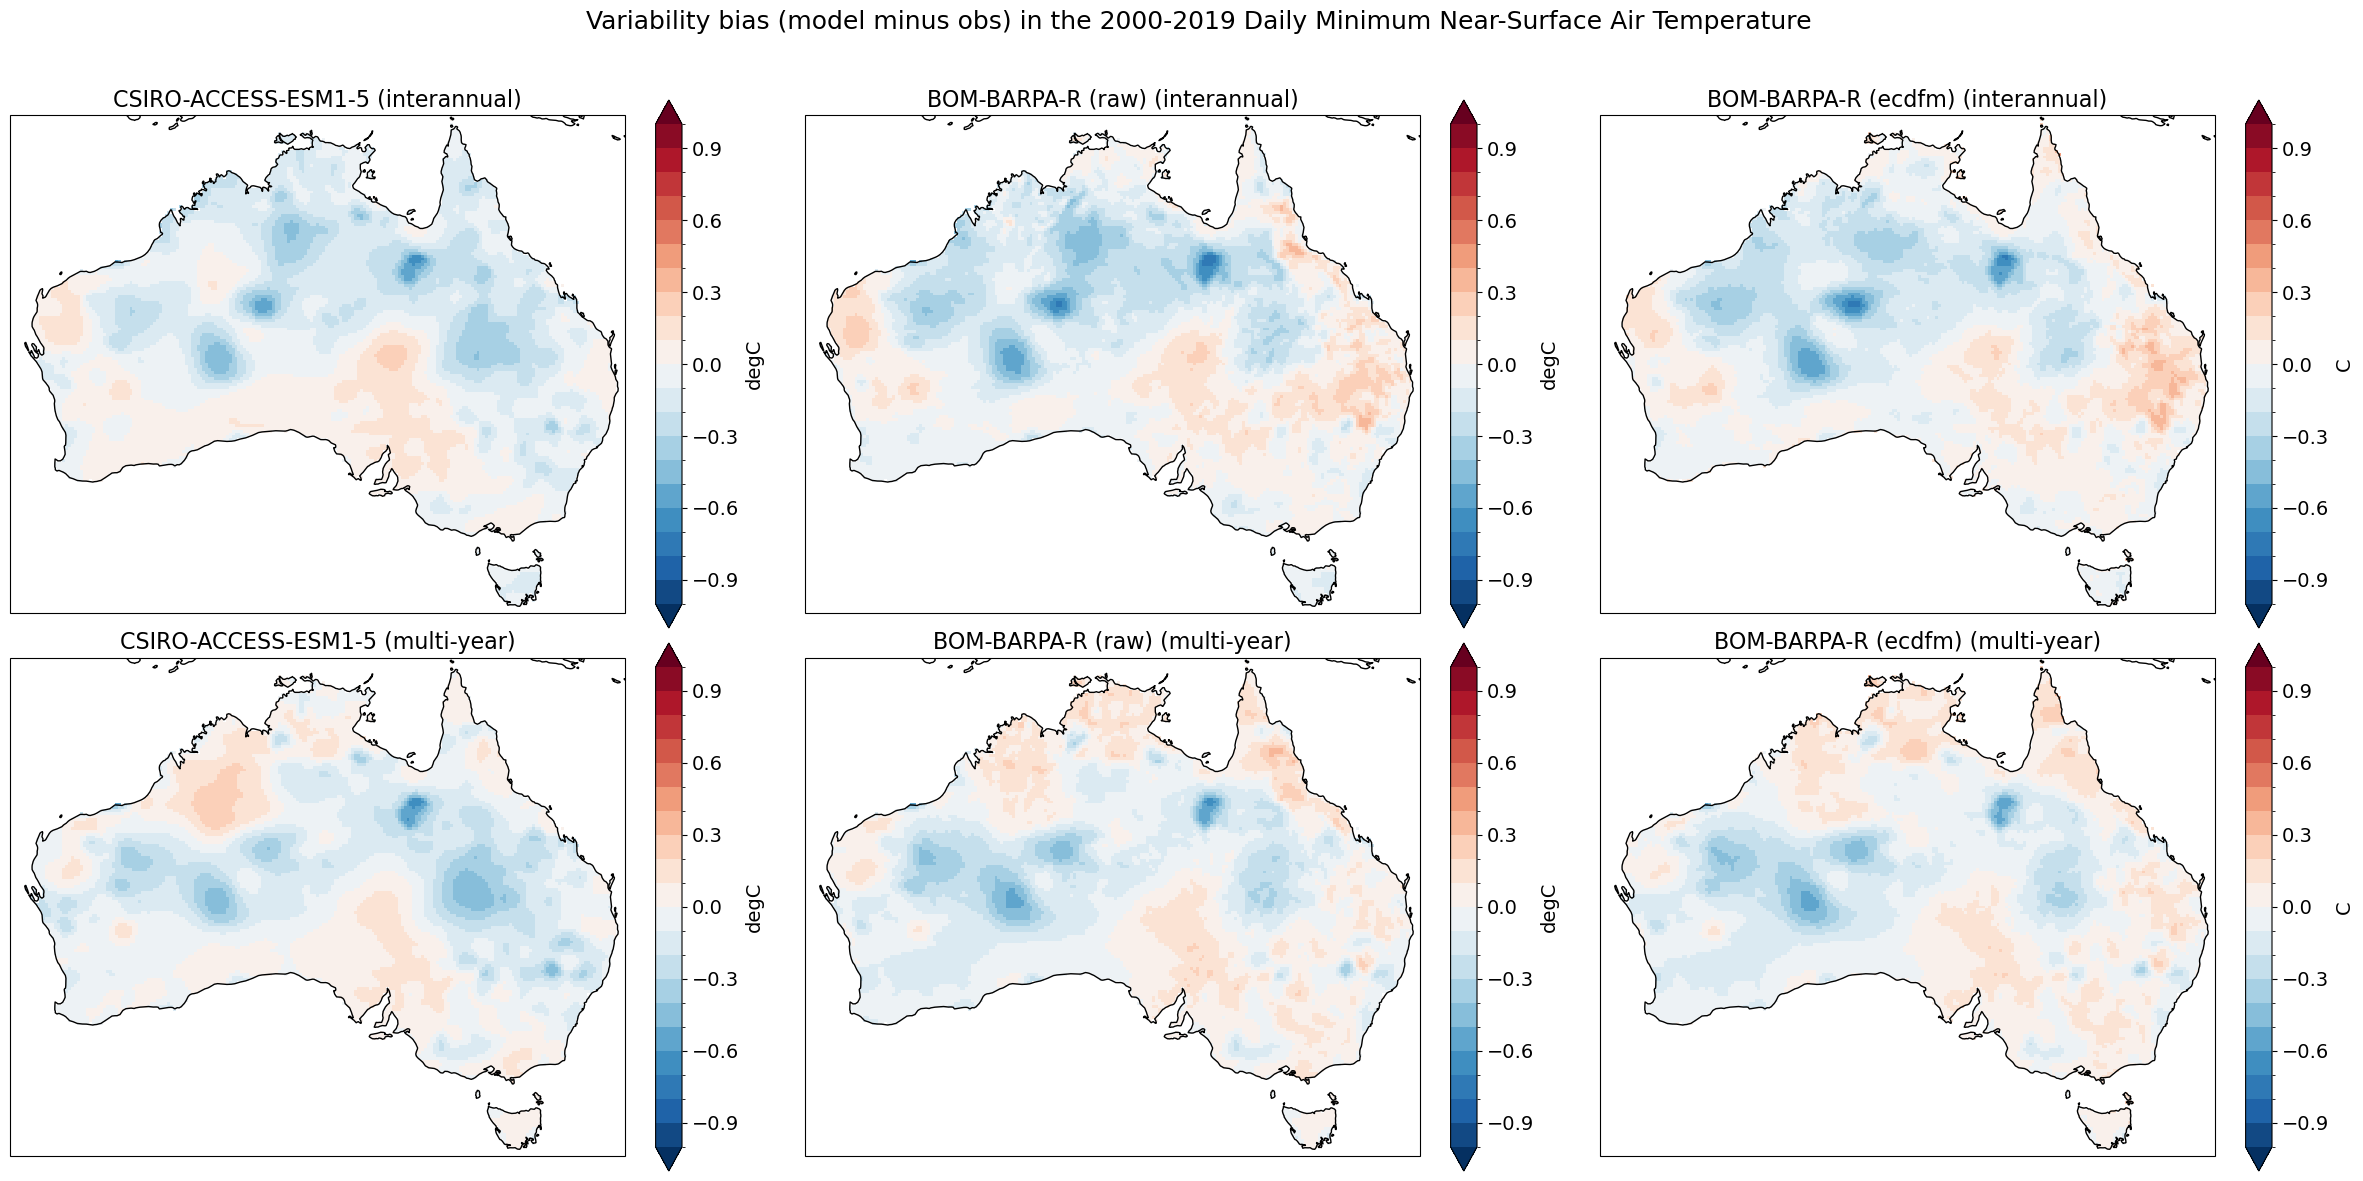

In [54]:
plot_comparison('tasmin', 'BOM-BARPA-R', 'RdBu_r', np.arange(-1, 1.01, 0.1))

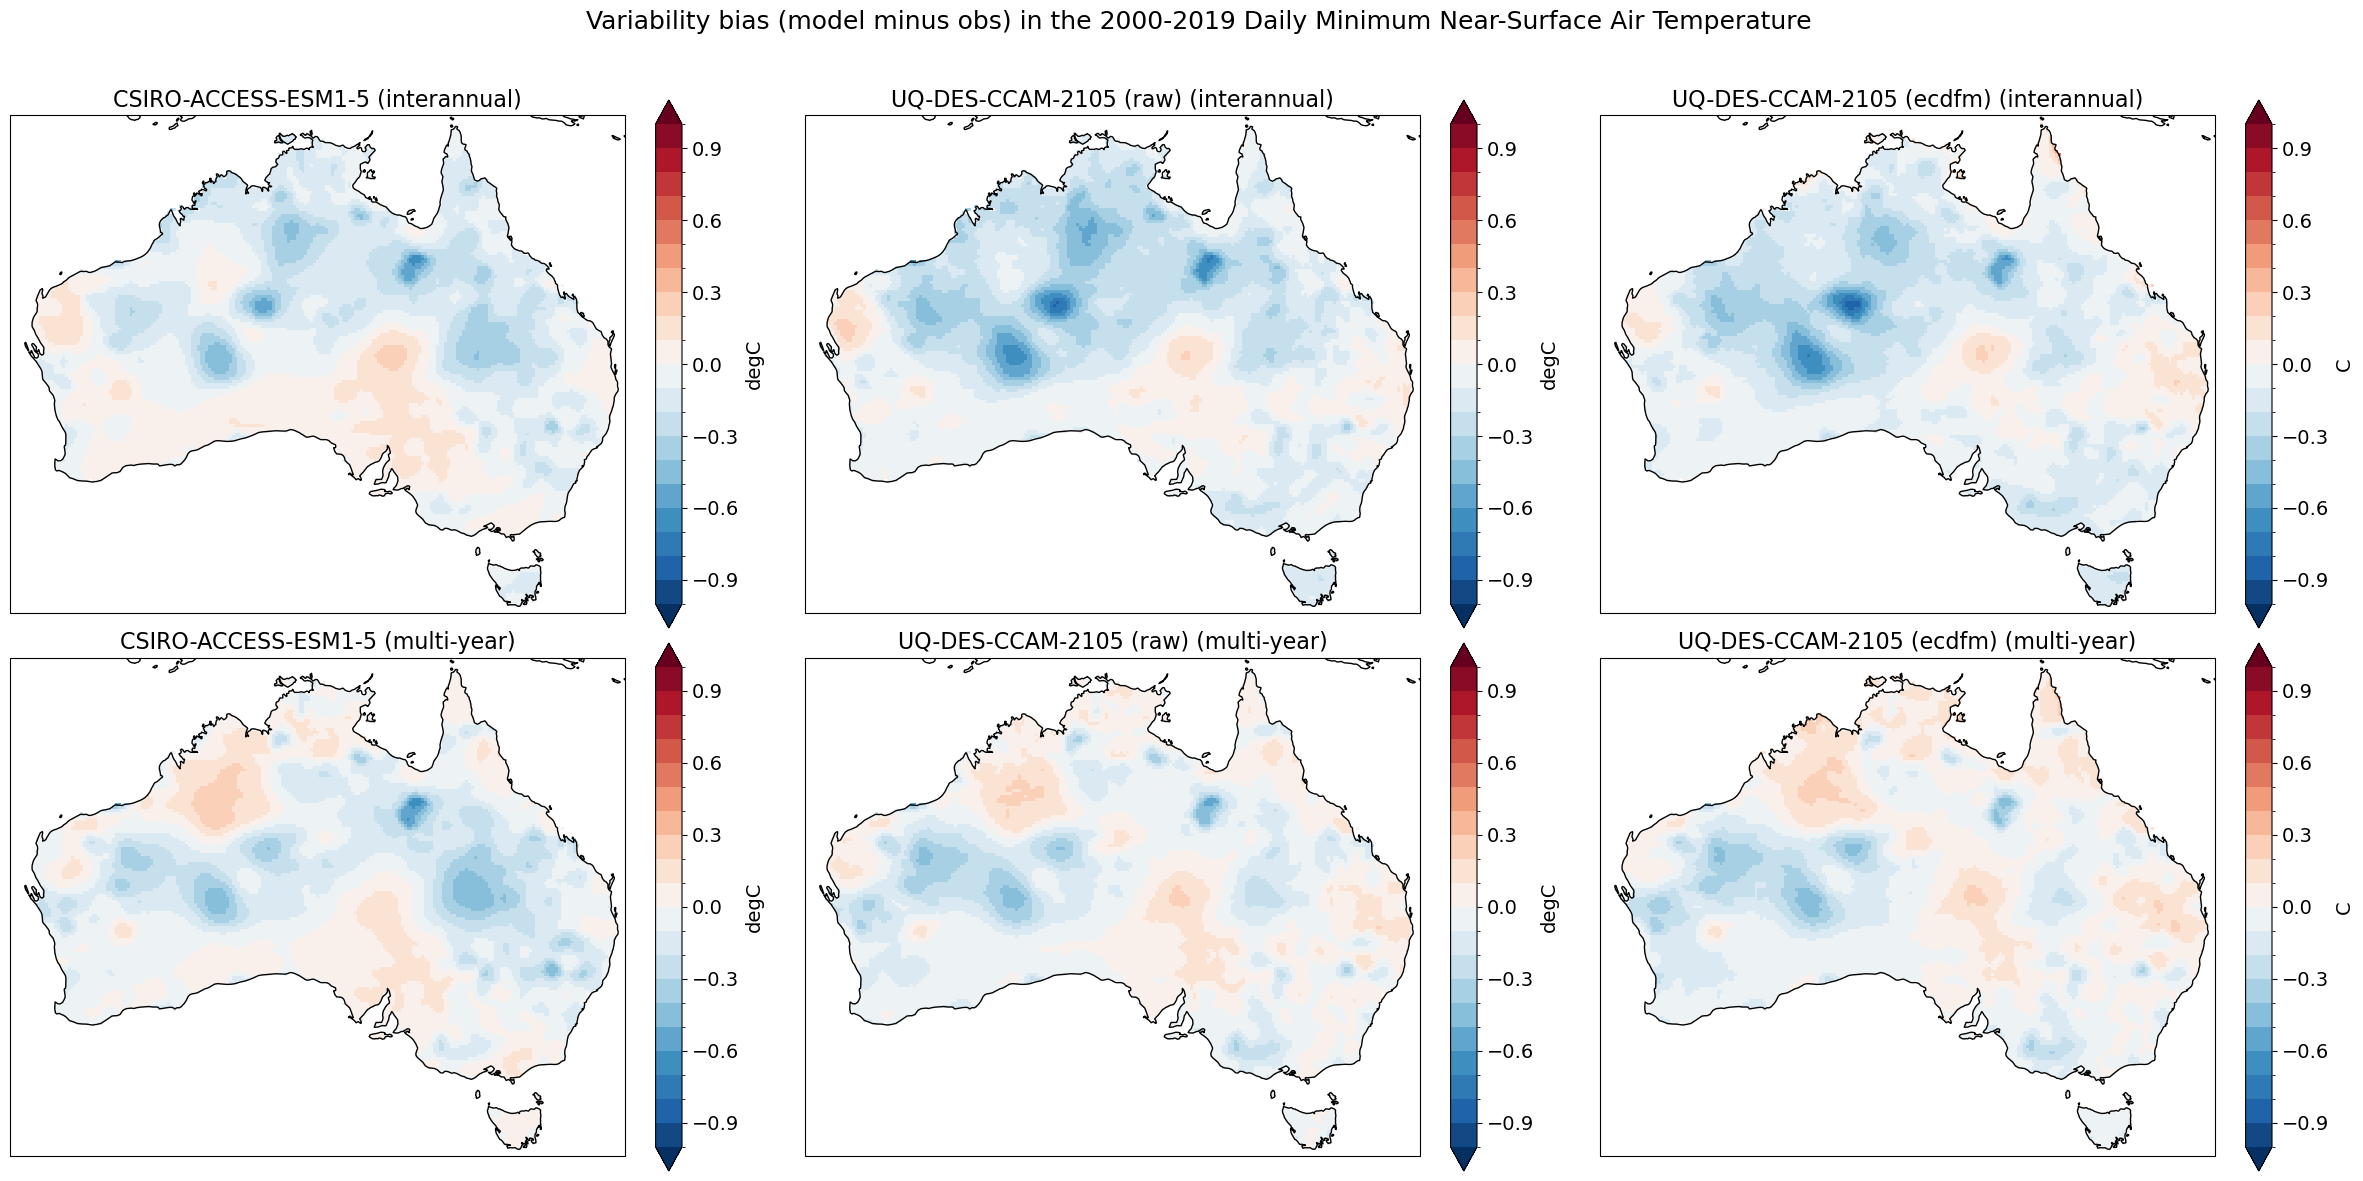

In [55]:
plot_comparison('tasmin', 'UQ-DES-CCAM-2105', 'RdBu_r', np.arange(-1, 1.01, 0.1))

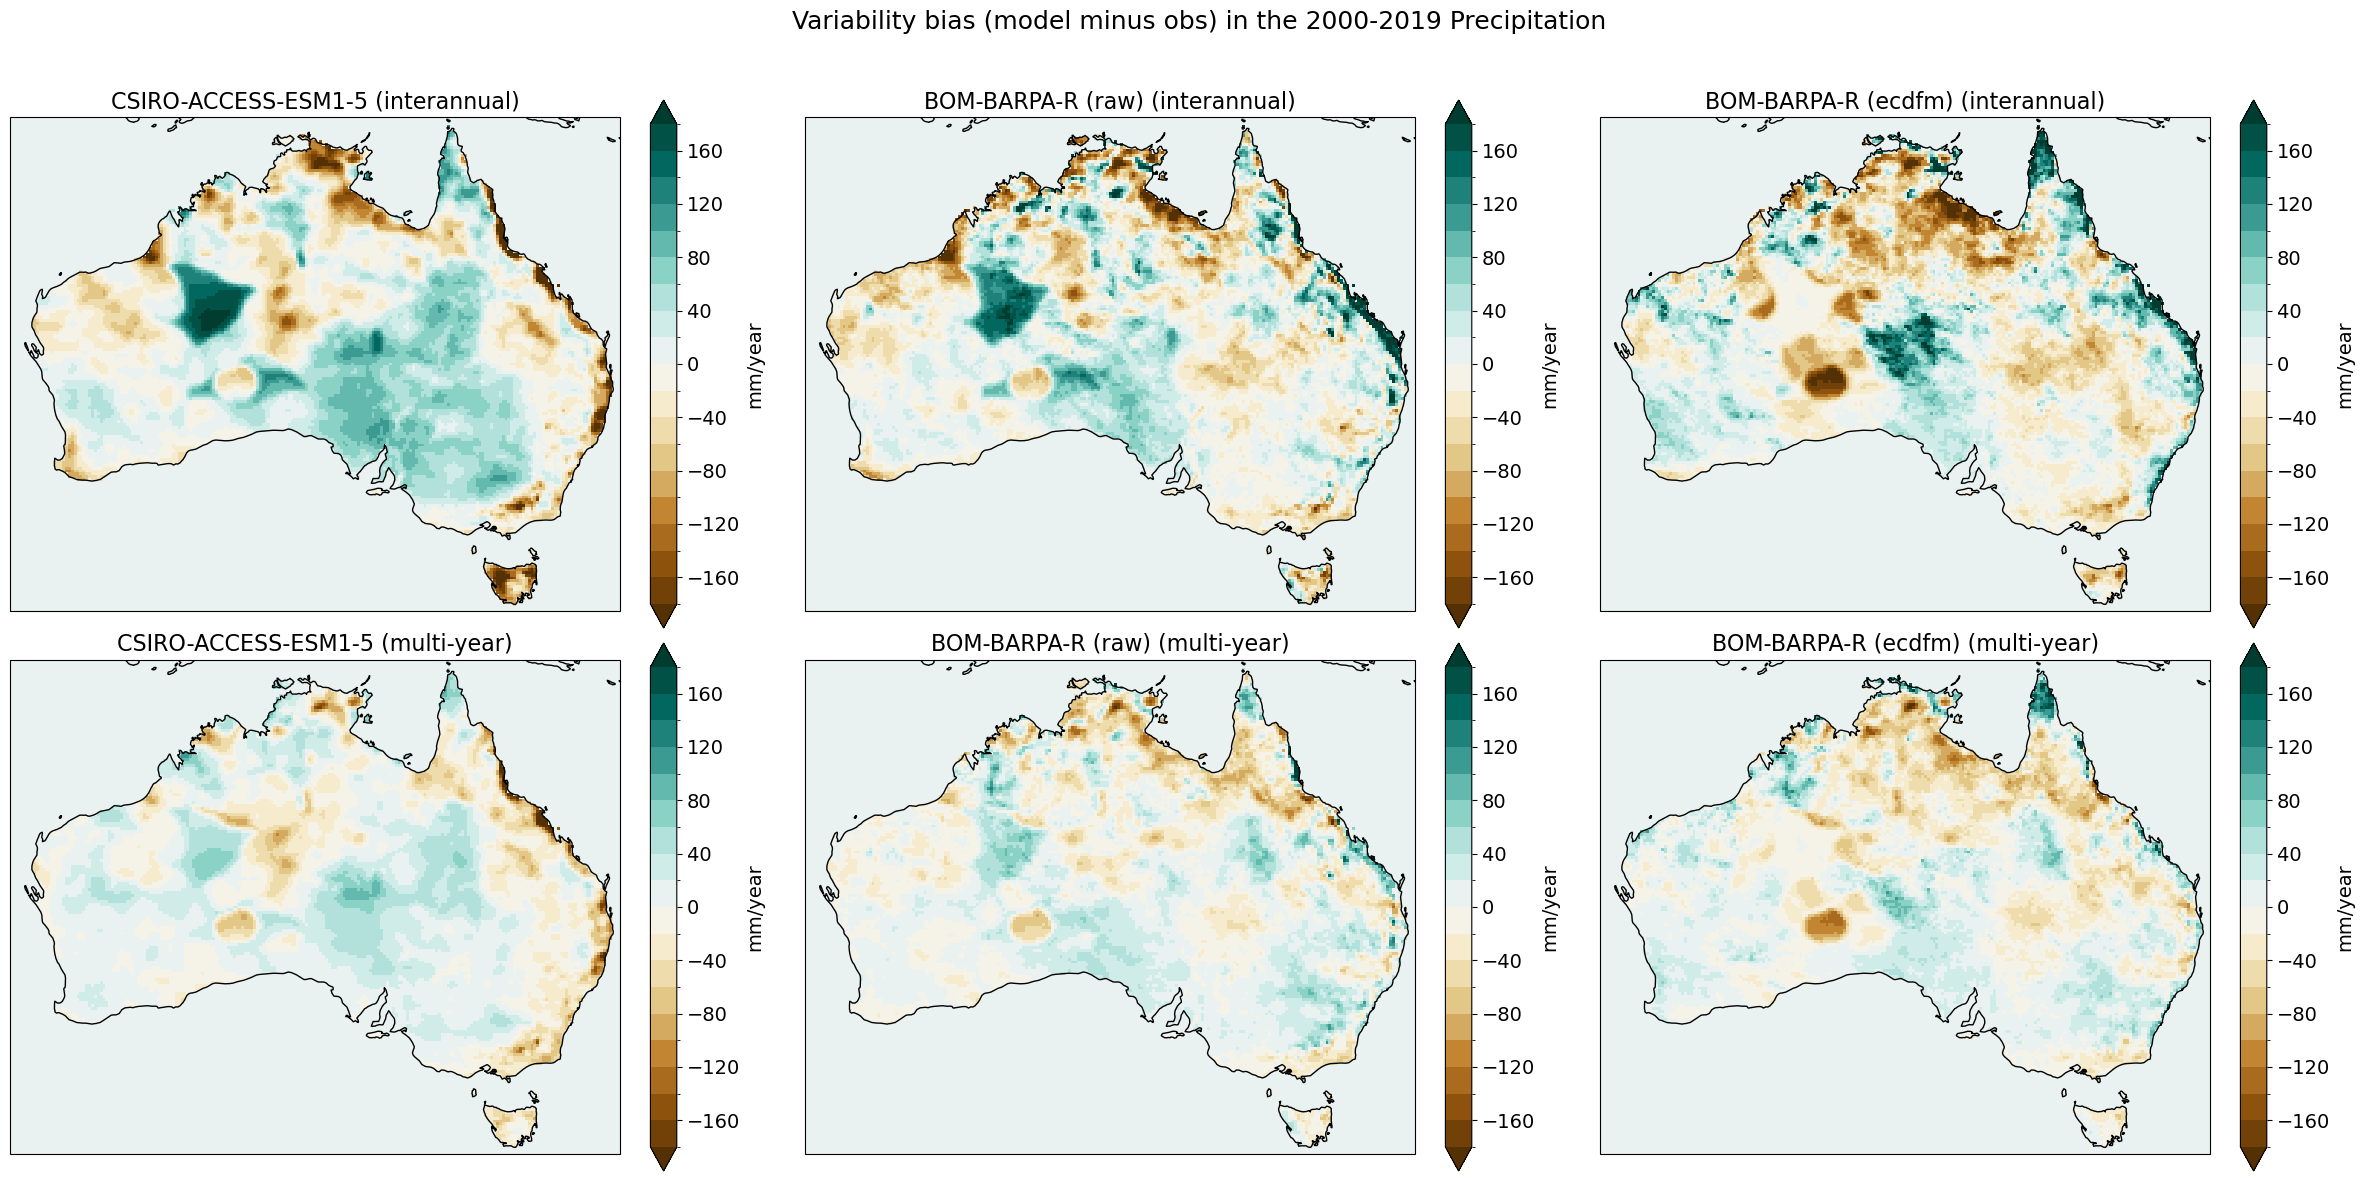

In [60]:
plot_comparison('pr', 'BOM-BARPA-R', 'BrBG', np.arange(-180, 180.1, 20))

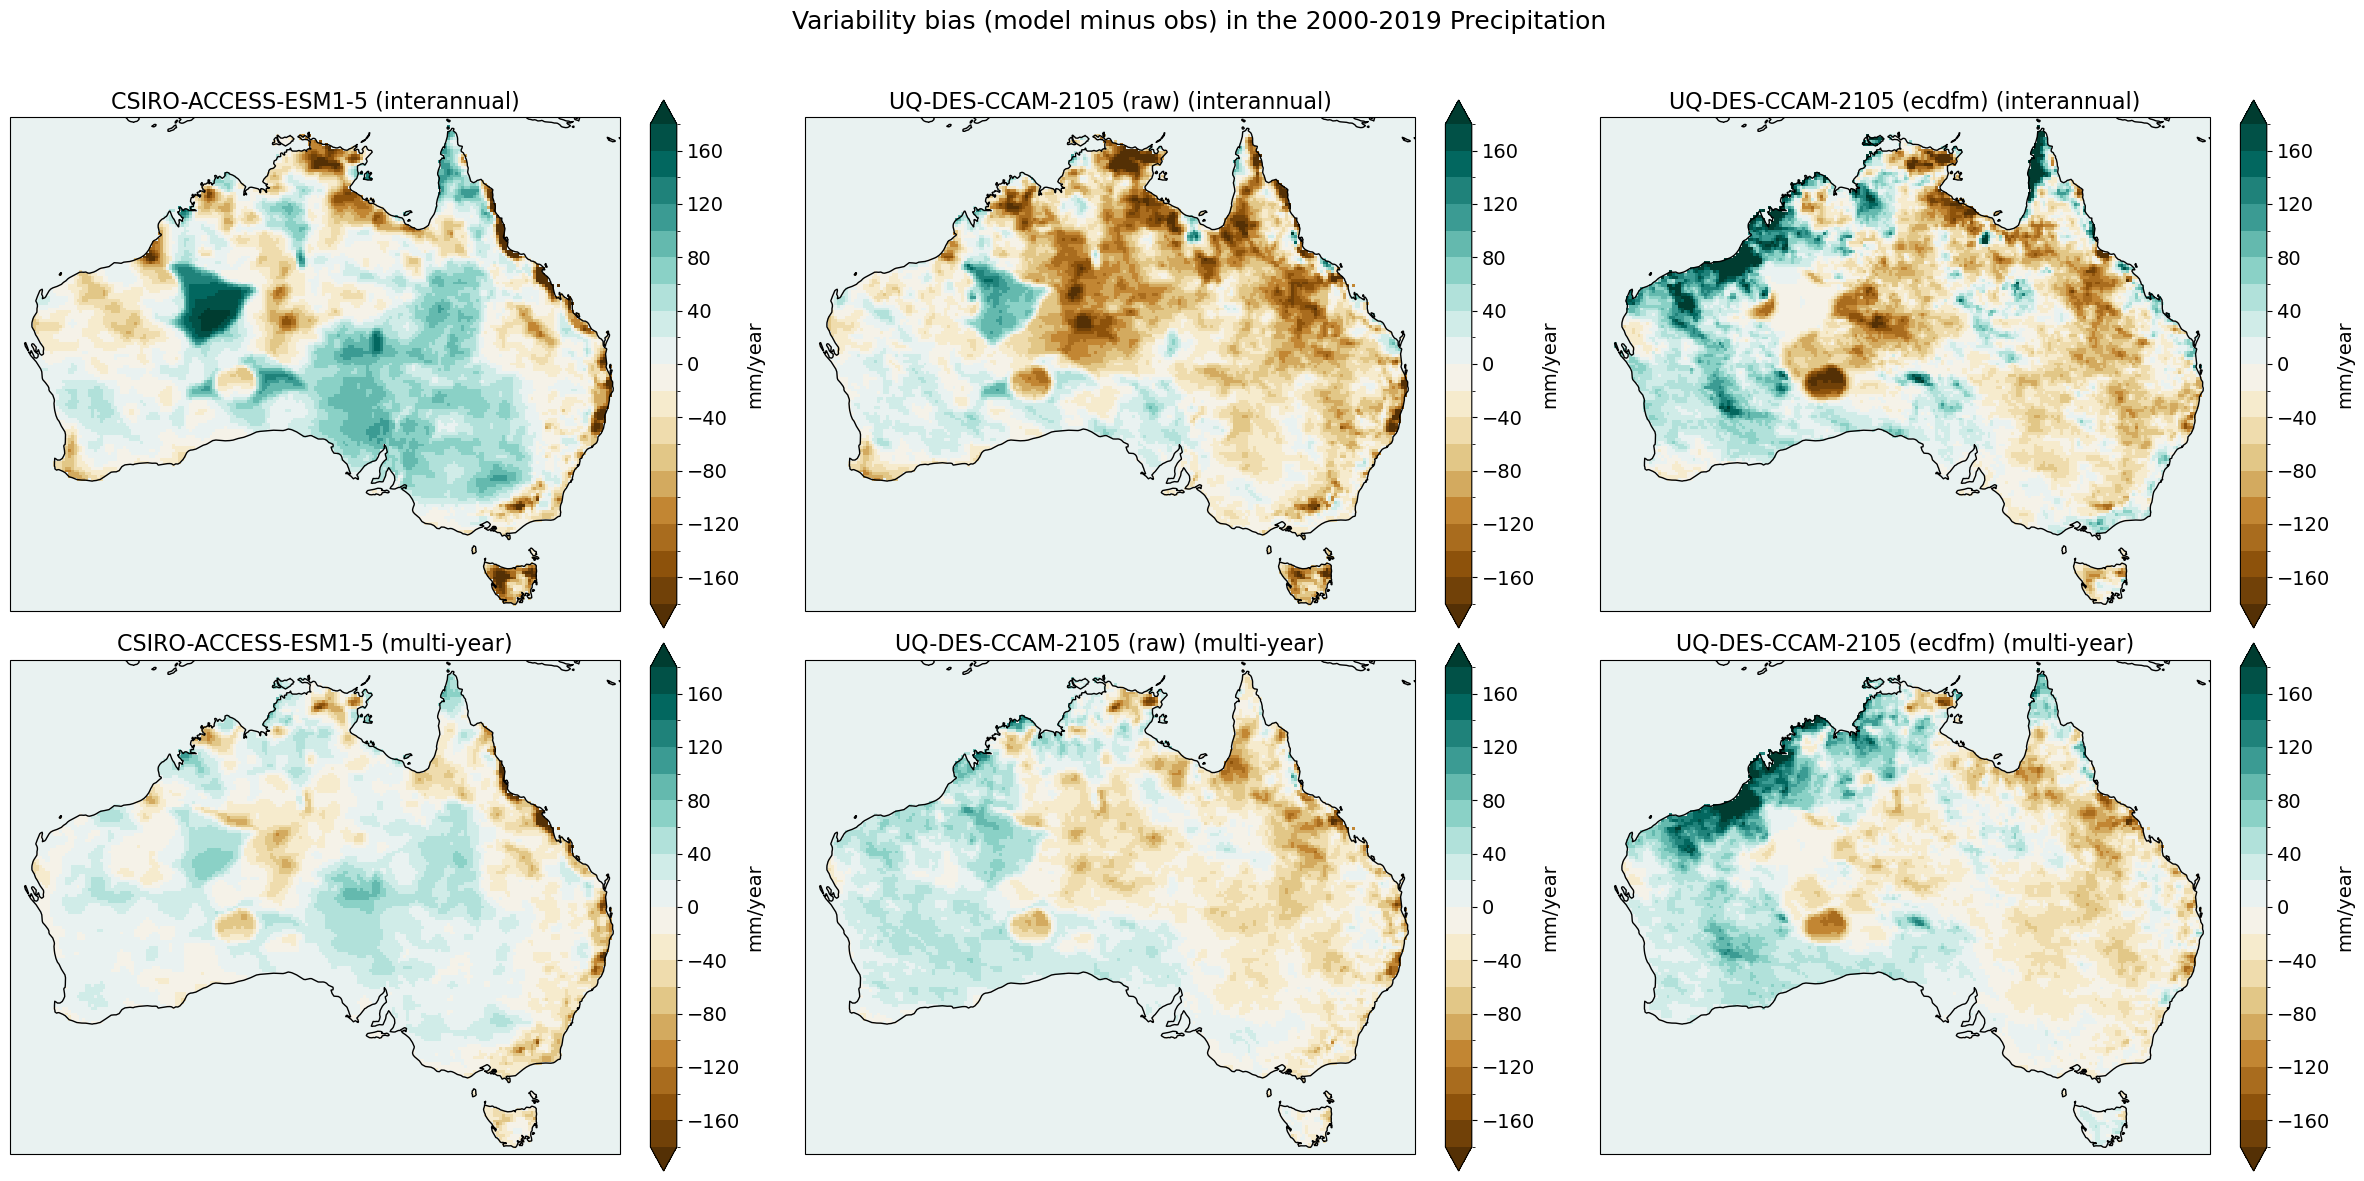

In [61]:
plot_comparison('pr', 'UQ-DES-CCAM-2105', 'BrBG', np.arange(-180, 180.1, 20))